# 1. Clusterización K-Means

**Objetivo:** hacer una clusterización de sismos históricos globales.

El centro nacional de información de sismos (NEIC) determina la ubicación y magnitud de los sismos más importantes que han ocurrido en el mundo y disemina esta información inmediatament a agencias nacionales e internacionales. 

https://www.kaggle.com/usgs/earthquake-database

**Información de las características**
This dataset includes a record of the date, time, location, depth, magnitude, and source of every earthquake with a reported magnitude 5.5 or higher since 1965.

* 0 Date
* 1 Time
* 2 Location
* 3 Depth
* 4 Magnitude
* 5 Source of the earthquake


**Número de instancias:** 23412

# 2. Autenticación de drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Importando librerías

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from sklearn.cluster import KMeans

In [ ]:
!pip install -U kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

# 4. Lectura del archivo y visualización de los datos

In [4]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.5 Clusterización'
name = 'NEIC_Earthquakes.csv'

In [5]:
sis_path = os.path.join(path,name)
sismosdf = pd.read_csv(sis_path)
sismosdf.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


Observemos que tenemos muchos campos con NaN, ¿Eliminamos las filas con NaN o las columnas?.
Visualizaremos que tan vacío está el dataframe con un mapa de calor

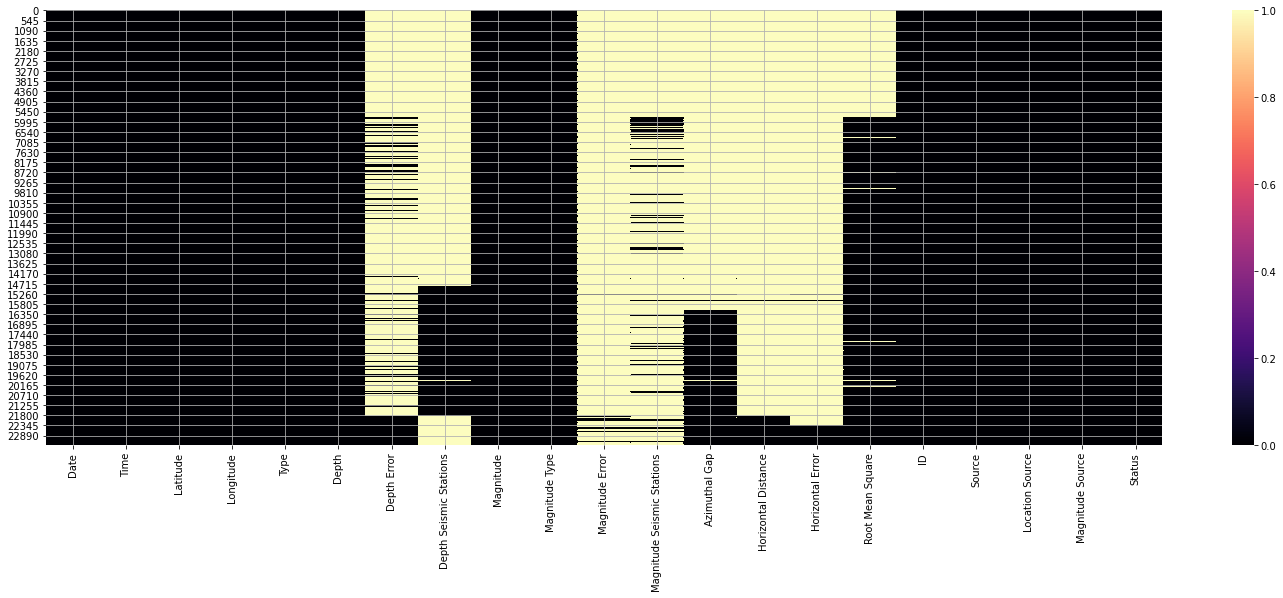

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
sns.heatmap(sismosdf.isnull(), ax=ax, cmap="magma")
plt.grid()
plt.show()

In [6]:
sismosdf.shape

(23412, 21)

# 5. Limpieza de los datos

Eliminar columnas con mayoría de campos indefinidos

In [7]:
sismosdf.drop(['Depth Error', 'Depth Seismic Stations', 'Magnitude Error',
               'Magnitude Seismic Stations', 'Azimuthal Gap', 'Horizontal Distance',
               'Horizontal Error', 'Root Mean Square', 'ID', 'Source',
               'Location Source', 'Magnitude Source', 'Status'], axis=1, inplace=True)

In [8]:
print(sismosdf.shape)
sismosdf.head()

(23412, 8)


,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,MW
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,MW
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,5.8,MW


Modificación de columna de Fecha

In [9]:
for i in range(sismosdf.shape[0]):
  try:
    or_time = sismosdf.iloc[i,0].split('/')
    year = or_time[-1]
    month = or_time[0]
    day = or_time[1]
    sismosdf.iloc[i,0] = year+'-'+month+'-'+day
  except:
    or_time = sismosdf.iloc[i,0].split('-')
    year = or_time[0]
    month = or_time[1]
    day = or_time[-1].split('T')
    sismosdf.iloc[i,0] = year+'-'+month+'-'+day[0]
    time = day[1].split('.')
    sismosdf.iloc[i,1] = time[0]

In [10]:
sismosdf.head(2)

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW


In [11]:
sismosdf.loc[:,'Fecha'] = pd.to_datetime(sismosdf.Date.astype(str)+' '+sismosdf.Time.astype(str))
sismosdf.drop(['Date','Time'], axis=1, inplace=True)
sismosdf = sismosdf[['Fecha', 'Latitude', 'Longitude',	'Type',	'Depth',	'Magnitude',	
                     'Magnitude Type']]
sismosdf.head(2)

,Fecha,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type
0,1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW
1,1965-01-04 11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW


Eliminación de instancias (filas) con valores idefinidos

In [12]:
sismosdf.dropna(axis=0, inplace=True)

In [13]:
sismosdf.shape

(23409, 7)

# 6. Exploración de los datos de sismos históricos

#### Revisando las columnas: Type, Magnitude Type

###### Columna Magnitude Type

In [14]:
sismosdf['Magnitude Type'].unique()

array(['MW', 'ML', 'MH', 'MS', 'MB', 'MWC', 'MD', 'MWB', 'MWW', 'MWR'],
      dtype=object)

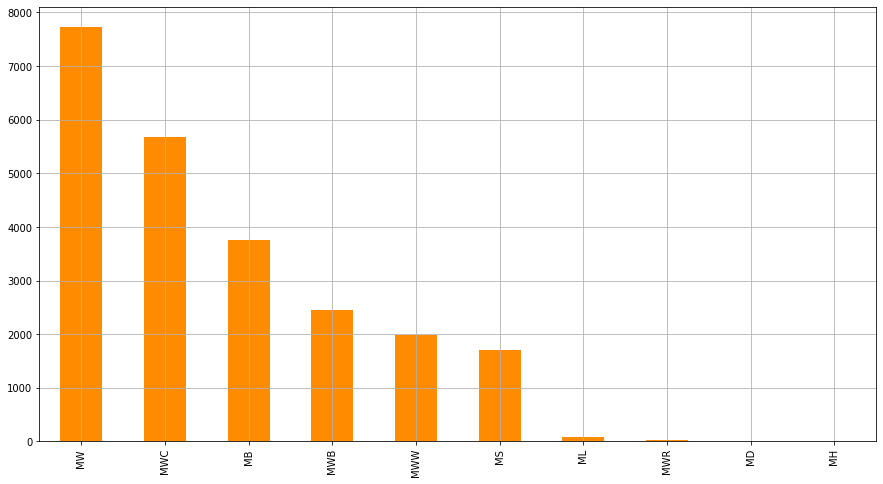

In [15]:
sismosdf['Magnitude Type'].value_counts().plot(kind='bar', figsize=(15,8), grid=True, color='darkorange')

##### Columna de magnitud

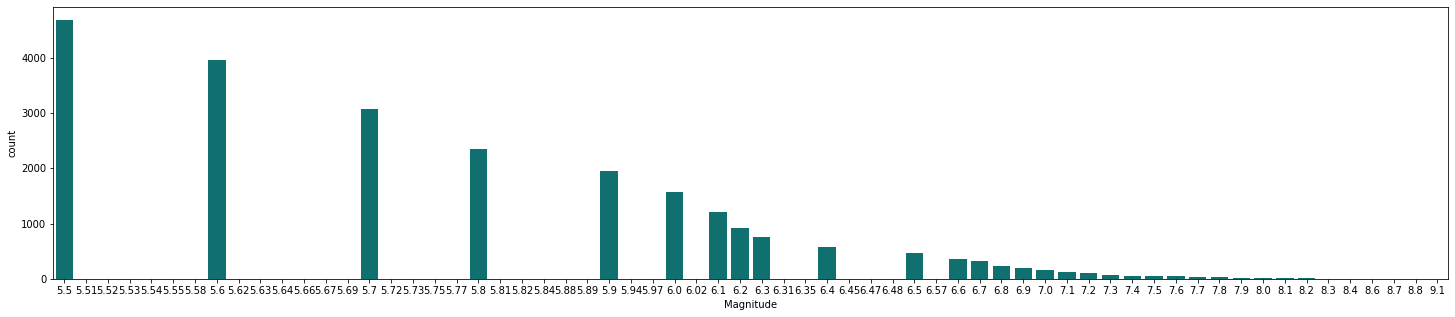

In [16]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(ax=ax, x=sismosdf['Magnitude'], color='teal')
plt.show()

##### Columna Type

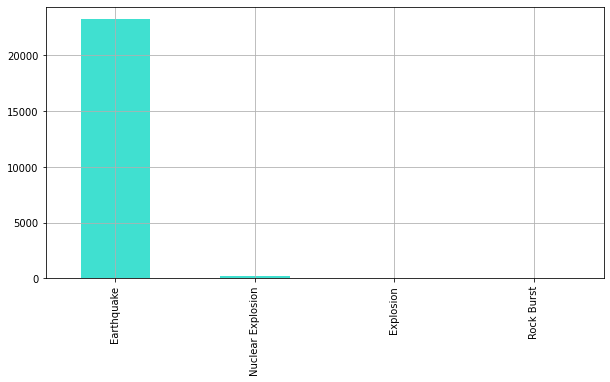

In [17]:
sismosdf['Type'].value_counts().plot(kind='bar', figsize=(10,5), grid=True, color='turquoise')

In [18]:
sismosdf = sismosdf[sismosdf.Type != 'Nuclear Explosion']
sismosdf = sismosdf[sismosdf.Type != 'Explosion']
sismosdf = sismosdf[sismosdf.Type != 'Rock Burst']

In [19]:
sismosdf.describe()

,Latitude,Longitude,Depth,Magnitude
count,23229.000000,23229.000000,23229.000000,23229.000000
mean,1.381597,39.766904,71.321828,5.882785
std,29.928026,125.746627,122.974352,0.424053
min,-77.080000,-179.997000,-1.100000,5.500000
25%,-18.721000,-76.352000,15.000000,5.600000
50%,-3.684900,106.379000,33.000000,5.700000
75%,24.959000,145.297000,54.800000,6.000000
max,86.005000,179.998000,700.000000,9.100000


In [25]:
fig = go.Figure(data=go.Scattergeo(
        lon = sismosdf['Longitude'],
        lat = sismosdf['Latitude'],
        text = sismosdf['Depth'],
        marker = dict(
        color = sismosdf['Magnitude'],
        colorscale = 'Rainbow',
        reversescale = True,
        opacity = 0.7,
        size = 2,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 0.1
        )
    )
        ))
fig.update_traces(marker=dict(size=5),
                  selector=dict(mode='markers'))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=25),
    title = 'Sismos históricos',
    #geo_scope='south america',
    )
fig.write_image("earthquake_magnitude.png")
fig.show()

In [21]:
sismosdf['Y'] = sismosdf['Fecha'].dt.year
sismosdf['M'] = sismosdf['Fecha'].dt.month
sismosdf = sismosdf.set_index(['Y', 'M'])
index_list = sismosdf.index.levels[0].tolist()
print(index_list)

[1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


In [30]:
frames=[{
        'name': 'frame_{}'.format(i),

        'data': [{
            'type': 'scattermapbox',
            'lat': sismosdf.xs(i)['Latitude'],
            'lon': sismosdf.xs(i)['Longitude'],
            'marker': go.scattermapbox.Marker(
                size=(sismosdf.xs(i)['Magnitude']-3.7)**3,
                color=sismosdf.xs(i)['Magnitude'],
                showscale=True,
                colorscale='Rainbow',
                colorbar={'title': 'Magnitude', 'titleside': 'top', 'thickness': 4, 'ticksuffix': ' Mgn'}
                ),
        'customdata': np.stack((
            sismosdf.xs(i)['Magnitude'],
            sismosdf.xs(i)['Depth'],
            pd.Series(sismosdf.xs(i).index)),
                axis=-1
                ),
        'hovertemplate': "<extra></extra><em> Magnitude  %{customdata[0]}<br>Depth  %{customdata[1]}",
        }],
    } for i in index_list]

sliders = [{
            'transition':{'duration': 0},
            'x':0.08,
            'len':0.88,
            'currentvalue':{'font':{'size':15}, 'prefix':'Año ', 'visible':True, 'xanchor':'center'},
            'steps':[
                {
                    'label':i,
                    'method':'animate',
                    'args':[
                        ['frame_{}'.format(i)],
                        {'mode':'immediate', 'frame':{'duration':1000, 'redraw': True}, 'transition':{'duration':500, }}
                      ],
                } for i in index_list]
        }]


# Primer cuadro
data = frames[0]['data']

# Añadiendo los sliders al layout
layout = go.Layout(
    sliders=sliders,
    margin=dict(l=0, r=0, b=0, t=25),
    title = 'Sismos históricos',
    mapbox={
        'accesstoken':'pk.eyJ1IjoiY2xhdWNvdCIsImEiOiJja2h4MTIxd2UwMzNzMnlvNzVycXN2dW14In0.J_KSzOY3YGDzozRdHvMJgQ',
        'center':{"lat": 0, "lon": 0},
        'zoom':1,
        'style':'light',
    }
)
fig = go.Figure(data=data, layout=layout, frames=frames)
fig.write_image("earthquake_magnitude.png")
fig.show()

# 7. Creación del modelo de clusterización

In [ ]:
fig = px.scatter(data_frame=sismosdf,
                    x='Magnitude',
                    y='Depth',
                    template='seaborn',
                    title='Magnitud vs Profundidad',
                    color_discrete_sequence=["darksalmon"],
                    width=1000,
                    height=500
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=25))
fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))
pio.show(fig)

#### Determinar el número de clusters adecuados

In [ ]:
X = np.array(sismosdf[['Magnitude', 'Depth']])

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
fig=go.Figure(layout=go.Layout(
        title=go.layout.Title(text="Gráfica del codo")
    ))
fig.update_xaxes(title_text='Número de clusters')
fig.update_yaxes(title_text='Score')
fig.add_scatter(x=pd.Series(Nc), y=pd.Series(score), mode='lines')
fig.update_layout(width=500, height=400, margin=dict(l=0, r=0, b=0, t=25))
pio.show(fig)

#### Ajuste de clusterización y cálculo de centroides

In [ ]:
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[  5.88082303  28.91834553]
 [  5.93843137 536.29446275]
 [  5.87053176 153.76544313]]


#### Cálculo de clusters

In [ ]:
labels = kmeans.predict(X)
print(pd.Series(labels).unique())

[2 0 1]


#### Creación de nuevo dataframe con etiquetas de clusters

In [ ]:
sismosdf['Tipo'] = labels
sismosdf.head()

,Fecha,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Tipo
0,1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW,2
1,1965-01-04 11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW,0
2,1965-01-05 18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,MW,0
3,1965-01-08 18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,MW,0
4,1965-01-09 13:32:50,11.938,126.427,Earthquake,15.0,5.8,MW,0


In [ ]:
sismosdf.replace({'Tipo': 0}, 'A', inplace=True)
sismosdf.replace({'Tipo': 1}, 'B', inplace=True)
sismosdf.replace({'Tipo': 2}, 'C', inplace=True)
sismosdf.head()

,Fecha,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Tipo
0,1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW,C
1,1965-01-04 11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW,A
2,1965-01-05 18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,MW,A
3,1965-01-08 18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,MW,A
4,1965-01-09 13:32:50,11.938,126.427,Earthquake,15.0,5.8,MW,A


#### Visualización de los clusters

In [ ]:
fig = px.scatter(data_frame=sismosdf,
                    x='Magnitude',
                    y='Depth',
                    color='Tipo',
                    color_discrete_sequence=["red", "blue", "green","darksalmon","turquosie"],
                    template='seaborn',
                    title='Clusterización de sismos',
                    width=1000,
                    height=500)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=25))
fig.update_traces(marker=dict(size=6),
                  selector=dict(mode='markers'))
fig.add_scatter(x=pd.Series(centroids[:,0]), y=pd.Series(centroids[:,1]), mode='markers', marker = dict(size = 20, color = 'magenta', symbol = 'star'))
pio.show(fig)